# Sentiment Analysis for Amazon Reviews

## Necessary imports and configurations

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [2]:
!pip install transformers

In [3]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.3 MB/s eta 0:00:00


The dataset was downloaded and uplodaed on drive to import it. The dataset is Amazon Food Reviws Dataset found on Kaggle. (https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews/)

In [4]:
# Mount Google Drive
from google.colab import drive

drive.mount('/content/gdrive')
zip_file_path = "/content/gdrive/MyDrive/ReviewsDataset/archive.zip"
extracted_folder_path = '/content/'
# Unzip the file using the command line
!unzip "$zip_file_path" -d "$extracted_folder_path"

Mounted at /content/gdrive
Archive:  /content/gdrive/MyDrive/ReviewsDataset/archive.zip
  inflating: /content/Reviews.csv    
  inflating: /content/database.sqlite  
  inflating: /content/hashes.txt     



##Exploring Dataset

In this section, our focus will be on the exploration of the Reviews Dataset.

In [5]:
df = pd.read_csv('/content/Reviews.csv')

In [6]:
df.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
df['Text'].values[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

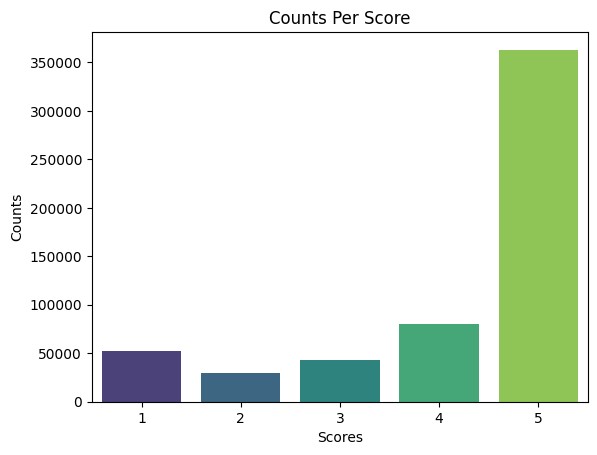

In [8]:
reviews_counts = df['Score'].value_counts().to_dict()
sns.barplot(x=list(reviews_counts.keys()), y=list(reviews_counts.values()), palette="viridis")

# Adding labels and title
plt.xlabel('Scores')
plt.ylabel('Counts')
plt.title('Counts Per Score')

# Show the plot
plt.show()

## Data Transformation

## Transform Data and Samling data
In this section, we aim to simplify the classification process. Scores exceeding 3 will be categorized as positive, a score of 3 will be considered neutral, and any score below 3 will be labeled as negative sentiment.

In [9]:
def assign_positive_negative_neutral_score(row):
  if row['Score'] > 3:
    return 'positive'
  elif row['Score'] == 3:
    return 'neutral'
  else:
    return 'negative'

In [10]:
df['Score'] = df.apply(assign_positive_negative_neutral_score, axis=1)

In [11]:
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,positive,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,negative,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,positive,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,positive,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


Check distribution of Scores after transformation


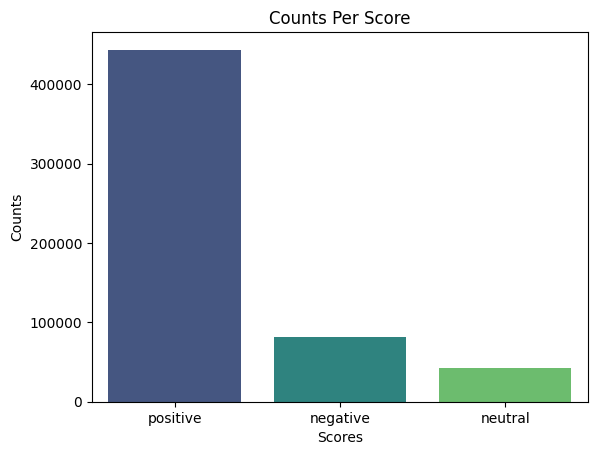

In [12]:
reviews_counts = df['Score'].value_counts().to_dict()
sns.barplot(x=list(reviews_counts.keys()), y=list(reviews_counts.values()), palette="viridis")

# Adding labels and title
plt.xlabel('Scores')
plt.ylabel('Counts')
plt.title('Counts Per Score')

# Show the plot
plt.show()

## Data Sampling

As shown by the figure below positive reviews acceed negative and neutral reviews drastically. That's why we're sticking with a manageable 100,000 samples, making sure we've got a fair mix from all the different classes.







In [13]:
filtered_positive_rows = df[df['Score'] == 'positive']
filtered_neutral_rows = df[df['Score'] == 'neutral']
filtered_negative_rows = df[df['Score'] == 'negative']
df = filtered_positive_rows.head(33333)
df = pd.concat([df, filtered_neutral_rows.head(33333)])
df = pd.concat([df, filtered_negative_rows.head(33334)])
df = df.reset_index(drop=True)
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
2,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...
3,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,positive,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
4,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,positive,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
...,...,...,...,...,...,...,...,...,...,...
99995,229010,B000MXHQQ6,AHMKQKJE55LJI,Amanda Greer,1,2,negative,1315785600,Nope,My baby likes the mac n cheese in the jars. So...
99996,229012,B000MXHQQ6,A91F5NPTH5HYZ,Mohamed Hassan,2,4,negative,1316563200,Pork gelatin!!!!!,I have just found out today that the gelatin i...
99997,229017,B000MXHQQ6,A2I9QM9L0R410A,SommMom,0,1,negative,1313020800,"Good product, but bad from Amazon",I love Gerber organic products like this which...
99998,229022,B000MXHQQ6,A3DAS42VRO66SN,"W. Wang ""Gadget Guy""",1,3,negative,1304380800,My twins hates it!,"I wouldn't say my twins are picky eater, but t..."


We can see how even the distribution is now.

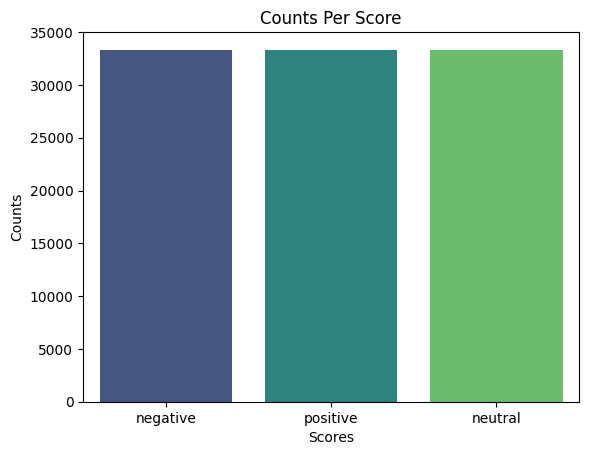

In [14]:
reviews_counts = df['Score'].value_counts().to_dict()
sns.barplot(x=list(reviews_counts.keys()), y=list(reviews_counts.values()), palette="viridis")

# Adding labels and title
plt.xlabel('Scores')
plt.ylabel('Counts')
plt.title('Counts Per Score')

# Show the plot
plt.show()

## Preprocessing text

Each text from the dataset will be pre-processed by removing symbols and extra white-spaces from it then converting its letters to lowercase.

In [15]:
def preprocess_text(row):
    symbols_to_remove = r'"#$%&\'()*+,-/:;<=>@[\]^_`{|}~'
    cleaned_text = re.sub(f'[{re.escape(symbols_to_remove)}]', '', row['Text'])
    processed_text = cleaned_text.replace('...', '.').replace('?', '.').replace('!', '.')
    processed_multiple_spaces = re.sub(r'\s+', ' ', processed_text)

    return processed_multiple_spaces.lower()

In [16]:
df['Text'] = df.apply(preprocess_text, axis=1)

In [17]:
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,i have bought several of the vitality canned d...
1,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",this is a confection that has been around a fe...
2,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,great taffy at a great price. there was a wide...
3,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,positive,1342051200,Nice Taffy,i got a wild hair for taffy and ordered this f...
4,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,positive,1340150400,Great! Just as good as the expensive brands!,this saltwater taffy had great flavors and was...
...,...,...,...,...,...,...,...,...,...,...
99995,229010,B000MXHQQ6,AHMKQKJE55LJI,Amanda Greer,1,2,negative,1315785600,Nope,my baby likes the mac n cheese in the jars. so...
99996,229012,B000MXHQQ6,A91F5NPTH5HYZ,Mohamed Hassan,2,4,negative,1316563200,Pork gelatin!!!!!,i have just found out today that the gelatin i...
99997,229017,B000MXHQQ6,A2I9QM9L0R410A,SommMom,0,1,negative,1313020800,"Good product, but bad from Amazon",i love gerber organic products like this which...
99998,229022,B000MXHQQ6,A3DAS42VRO66SN,"W. Wang ""Gadget Guy""",1,3,negative,1304380800,My twins hates it!,i wouldnt say my twins are picky eater but the...


## Bag of words approach (VADER)

In [28]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
sia = SentimentIntensityAnalyzer()

In [29]:
sia.polarity_scores('I am glad')

{'neg': 0.0, 'neu': 0.25, 'pos': 0.75, 'compound': 0.4588}

In [30]:
sia.polarity_scores('I am not that glad')

{'neg': 0.453, 'neu': 0.547, 'pos': 0.0, 'compound': -0.357}

In [31]:
def classify_vader_sentiment(compound):
  if compound >=  0.05:
    return 'positive'
  elif compound <= - 0.05:
    return 'negative'
  else:
    return 'neutral'

In [ ]:
res = []
for i, row in tqdm(df.iterrows(), total=len(df)):
  res.append(classify_vader_sentiment((sia.polarity_scores(row['Text'])['compound'])))

  0%|          | 0/100000 [00:00<?, ?it/s]

In [ ]:
vaders_scores_df = df
vaders_scores_df['Score Vaders'] = res

In [ ]:
vaders_scores_df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Score Vaders
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,i have bought several of the vitality canned d...,positive
1,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",this is a confection that has been around a fe...,positive
2,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,great taffy at a great price. there was a wide...,positive
3,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,positive,1342051200,Nice Taffy,i got a wild hair for taffy and ordered this f...,positive
4,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,positive,1340150400,Great! Just as good as the expensive brands!,this saltwater taffy had great flavors and was...,positive
...,...,...,...,...,...,...,...,...,...,...,...
99995,229010,B000MXHQQ6,AHMKQKJE55LJI,Amanda Greer,1,2,negative,1315785600,Nope,my baby likes the mac n cheese in the jars. so...,positive
99996,229012,B000MXHQQ6,A91F5NPTH5HYZ,Mohamed Hassan,2,4,negative,1316563200,Pork gelatin!!!!!,i have just found out today that the gelatin i...,positive
99997,229017,B000MXHQQ6,A2I9QM9L0R410A,SommMom,0,1,negative,1313020800,"Good product, but bad from Amazon",i love gerber organic products like this which...,positive
99998,229022,B000MXHQQ6,A3DAS42VRO66SN,"W. Wang ""Gadget Guy""",1,3,negative,1304380800,My twins hates it!,i wouldnt say my twins are picky eater but the...,neutral


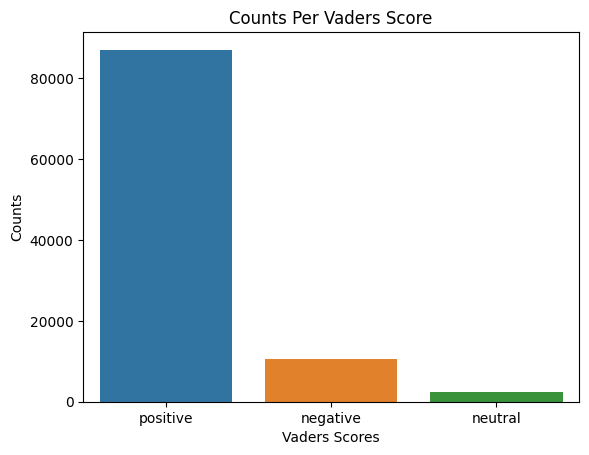

In [ ]:
counts = vaders_scores_df['Score Vaders'].value_counts()
sns.barplot(x= counts.index, y= counts.values)

# Adding labels and title
plt.xlabel('Vaders Scores')
plt.ylabel('Counts')
plt.title('Counts Per Vaders Score')

# Show the plot
plt.show()

VADER cannot capture neutral texts efficiently. It is noticed by the drop of the total number of neutral texts in the dataset.

## Text-To-Text Model (T5)


### Configuration

Loading pre-trained model from Hugging Face Hub.

In [18]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW

model_name = "t5-base"
model = T5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = T5Tokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the

In [19]:
model.config.vocab_size

32128

Split data into two parts: training data and test data.

In [20]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels= train_test_split(df['Text'], df['Score'], test_size=0.2, random_state=42)

# Reset index
train_data = train_data.reset_index(drop=True)
test_data =  test_data.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

Creating our own Custom Dataset

In [21]:
from torch.utils.data import Dataset, DataLoader
import torch

class ReviewsDataset(Dataset):

  def __init__(self, texts, labels, tokenizer, max_length):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_length = max_length


  def __len__(self):
    return len(self.texts)


  def __getitem__(self, index):
    try:
        encoding = self.tokenizer(
            self.texts[index],
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt',
        )

        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        labels = tokenizer(self.labels[index] + " </s>", return_tensors='pt', max_length=2)
        input_labels = labels['input_ids'].squeeze()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': input_labels
        }
    except Exception as e:
        print(f"Error at index {index}: {str(e)}")
        raise

Split Training Data and Test Data into batches for batch processing.

In [22]:
train_dataset = ReviewsDataset(train_data, train_labels, tokenizer, 100)
test_dataset = ReviewsDataset(test_data, test_labels, tokenizer, 100)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Choosing optimizer and number of training epochs.

In [23]:
optimizer = AdamW(model.parameters(), lr=2e-4, weight_decay=1e-2)
num_epochs = 3

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Training

In [24]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print_interval = 100

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    counter = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        counter += 1

        # Print the loss every print_interval batches
        if counter % print_interval == 0:
            average_loss = total_loss / print_interval
            print("============================================")
            print(f"Epoch {epoch + 1}, Batch {counter}, Average Loss: {average_loss}")
            total_loss = 0.0  # Reset total_loss for the next set of batches

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Epoch 1, Batch 100, Average Loss: 0.8591140776872634
Epoch 1, Batch 200, Average Loss: 0.320804231017828
Epoch 1, Batch 300, Average Loss: 0.3121370454132557
Epoch 1, Batch 400, Average Loss: 0.2978303995728493
Epoch 1, Batch 500, Average Loss: 0.29439965561032294
Epoch 1, Batch 600, Average Loss: 0.2918277345597744
Epoch 1, Batch 700, Average Loss: 0.27699395403265953
Epoch 1, Batch 800, Average Loss: 0.2771133679151535
Epoch 1, Batch 900, Average Loss: 0.27067403852939603
Epoch 1, Batch 1000, Average Loss: 0.2678749245405197
Epoch 1, Batch 1100, Average Loss: 0.26261316433548926
Epoch 1, Batch 1200, Average Loss: 0.2587962658703327
Epoch 2, Batch 100, Average Loss: 0.2314120650291443
Epoch 2, Batch 200, Average Loss: 0.22982347548007964
Epoch 2, Batch 300, Average Loss: 0.22953647255897522
Epoch 2, Batch 400, Average Loss: 0.229470574259758
Epoch 2, Batch 500, Average Loss: 0.22256775975227355
Epoch 2, Batch 600, Average Loss: 0.23058543875813484
Epoch 2, Batch 700, Average Loss: 0.2

### Inference

In [25]:
input_text = "My experience with this product was a mix of positives and areas for improvement, from efficient features like quality to occasional hiccups and a need for more detailed customer assistance. The pricing is fair, but careful consideration is advised based on individual needs."

# Tokenize the input text
inputs = tokenizer(input_text, return_tensors='pt', padding=True, truncation=True)

# Specify both input_ids and attention_mask
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']

# Set Model to evaluation mode
model.eval()
with torch.no_grad():
# Forward pass through the model
  output_ids = model.generate(input_ids=input_ids.to(device), attention_mask=attention_mask.to(device), max_length=2, num_beams=5, length_penalty=0.6)

# Flatten the list of generated tokens
flat_output_ids = output_ids.flatten().tolist()

# Decode and print the generated output
decoded_output = tokenizer.decode(flat_output_ids, skip_special_tokens=True)
print(input_text+ ' :')
print(decoded_output)

My experience with this product was a mix of positives and areas for improvement, from efficient features like quality to occasional hiccups and a need for more detailed customer assistance. The pricing is fair, but careful consideration is advised based on individual needs. :
neutral


### Saving Fine Tuned

In [26]:
model.save_pretrained("/content/final_fine_tuned_model")

In [27]:
import shutil
from google.colab import files

directory_path = '/content/final_fine_tuned_model'
shutil.make_archive('final_fine_tuned_model', 'zip', directory_path)
drive_path = '/content/gdrive/My Drive/'

shutil.move('final_fine_tuned_model.zip', drive_path + 'final_fine_tuned_model')

'/content/gdrive/My Drive/final_fine_tuned_model_december'

### Loading Fine Tuned

It is now possible to load the saved fine tuned model.

In [ ]:
import zipfile
import os
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Specify the path to the zip file where we are going to save it on drive
zip_file_path = "/content/gdrive/MyDrive/final_fine_tuned_model"

# Specify the directory where we want to extract the contents
extracted_dir = "/content/gdrive/MyDrive/Fine_tuned/final_fine_tuned_model_extracted"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

# Load the model and tokenizer from the extracted directory
model = T5ForConditionalGeneration.from_pretrained(extracted_dir)

## Performance comparison

### VADER Performance

In [32]:
# Get test data and test labels and concat them into a new dataframe
df_test = pd.concat([test_data , test_labels], axis=1)
df_test

,Text,Score
0,the picture shows redskin peanuts with skin on...,negative
1,this product is bad. i ordered 3 cases of this...,negative
2,i am delighted to find that bakers hot chocola...,positive
3,i was shopping a little too quickly and subscr...,negative
4,i purchased this because another reviewer like...,negative
...,...,...
19995,i have been using this product for years and a...,positive
19996,i have several types of baby food molds and th...,positive
19997,if you are used to buying the piggy twists tha...,neutral
19998,i bought these after having a minor freak out ...,neutral


In [33]:
total_correct = 0
total = len(df_test)
# Loop over all test rows and check total number of correct predictions
for i, row in tqdm(df_test.iterrows(), total=len(df_test)):
    if (classify_vader_sentiment((sia.polarity_scores(row['Text'])['compound'])) == row['Score']):
      total_correct += 1

accuracy_vader = float(total_correct/total)
print('Test_accuracy VADER=',str(accuracy_vader))

  0%|          | 0/20000 [00:00<?, ?it/s]

Test_accuracy VADER= 0.45835


### T5 Performance

In [34]:
def compute_accuracy_T5(model, test_loader, device):
  total_correct = 0
  total = 0
  for batch in test_loader:
      accuracy_batch = []
      inputs_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels_batch = batch['labels']
      decoded_labels_batch = [tokenizer.decode(labels, skip_special_tokens=True) for labels in labels_batch]
      model.eval()
      with torch.no_grad():
        output_ids = model.generate(input_ids=inputs_ids, attention_mask=attention_mask, max_length=2, num_beams=5, length_penalty=0.6)
      flat_output_ids = output_ids.flatten().tolist()
      decoded_output = np.array(tokenizer.decode(flat_output_ids, skip_special_tokens=True).split(' '))
      equal_labels = decoded_output == decoded_labels_batch
      total_correct += np.sum(equal_labels)
      total += len(inputs_ids)

  return(float(total_correct/total))

In [35]:
test_accuracy_T5 = compute_accuracy_T5(model, test_loader, device)
print('Test_accuracy of T5=' + str(test_accuracy_T5))

Test_accuracy of T5=0.8336


### Conclusion

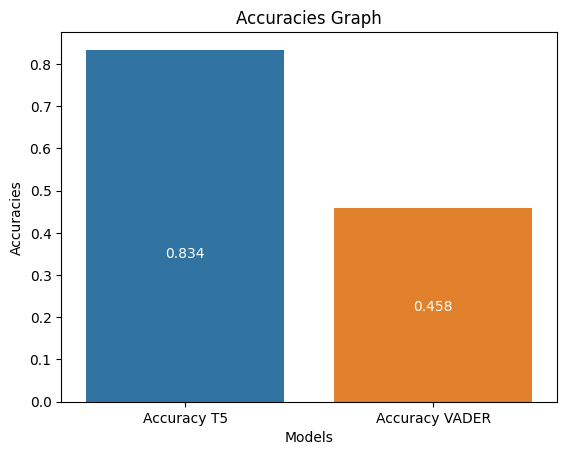

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

categories = ['Accuracy T5', 'Accuracy VADER']
values = [test_accuracy_T5, accuracy_vader]

# Create a bar plot
ax = sns.barplot(x=categories, y=values)

# Add accuracy value on each bar
for i, v in enumerate(values):
    if i==0:
      ax.text(i, v - 0.5, '{:.3f}'.format(v), ha='center', va='bottom', color='white')
    else:
      ax.text(i, v - 0.25, '{:.3f}'.format(v), ha='center', va='bottom', color='white')


# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracies')
plt.title('Accuracies Graph')

# Show the plot
plt.show()

T5 perfomed better than the VADER model since T5 is able to capture more long range-dependencies inside sequences of text thanks to the Attention Mechanism.